# Part 5. Time series forecasting - exercise

> Try your best in one of the Monash datasets!

Today you'll apply the knowledge acquired in part 5 to perform forecasting on one
of the datasets from the Monash time series forecasting archive (TSF). You don't
have to build the TSC algorithm from scratch if you don't want to, but rather make
use of high level tools. Use the ones used in previous exercises such as:
- [aeon](https://github.com/aeon-toolkit/aeon)
- [tsai](https://github.com/timeseriesAI/tsai)
- [tslearn](https://github.com/tslearn-team/tslearn#available-features)
- [sk-time](https://github.com/sktime/sktime)

Or new ones seen in this course:
- [statsmodels](https://www.statsmodels.org/stable/index.html). Implements traditional
statistical forecasting models.
- [pytorch-forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/): Pytorch
library built on top of [pytorch lightning](https://lightning.ai/docs/pytorch/stable/)
that implements several neural forecasting models including NHiTS.

We are going to use the sunspot dataset. This dataset contains a single very long
daily time series of sunspot numbers from 1818-01-08 to 2020-05-31. Be aware that
there is missing data. The nonmissing data version of this dataset was filled with
the LOCV method of imputation.

## Preparing the data

Running the following code is **mandatory**, as it will load the datasets as meant for
the competition.

### Download

In [1]:
import requests
import zipfile
import os
url_train = 'https://zenodo.org/api/records/4654773/files-archive'
url_test = 'https://zenodo.org/api/records/4654722/files-archive'
# Download the zip file

DATA_FOLDER = 'data'
TEMP_FOLDER = 'raw_data'

response = requests.get(url_train)

def get(url):
    response = requests.get(url)
    zip_file_path = os.path.join(TEMP_FOLDER,'temp.zip')  # Specify the path to save the zip file
    with open(zip_file_path, 'wb') as file:
        file.write(response.content)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(TEMP_FOLDER)
    os.remove(zip_file_path)

def extract():
    extracted_zipfile = list(os.listdir(TEMP_FOLDER))[0]
    extracted_zipfile = os.path.join(TEMP_FOLDER, extracted_zipfile)
    with zipfile.ZipFile(extracted_zipfile, 'r') as zip_ref:
        zip_ref.extractall(DATA_FOLDER)
    os.remove(extracted_zipfile)

if not os.path.exists(TEMP_FOLDER):
    os.mkdir(TEMP_FOLDER)
if not os.path.exists('data'):
    os.mkdir(DATA_FOLDER)

get(url_train)
extract()
get(url_test)
extract()

os.rmdir(TEMP_FOLDER)

### Load to memory

In [2]:
# We use the aeon package to load the data. use ``!pip3 install aeon''
from aeon.datasets import load_from_tsf_file

#DATA_FOLDER = 'data' # Specify if the dataset is alread downloaded
TRAIN_DATA_FOLDER = os.path.join(DATA_FOLDER, 'sunspot_dataset_with_missing_values.tsf')
TEST_DATA_FOLDER = os.path.join(DATA_FOLDER, 'sunspot_dataset_without_missing_values.tsf')

missing_data, missing_metadata = load_from_tsf_file(TRAIN_DATA_FOLDER)
nonmissing_data, nonmissing_metadata = load_from_tsf_file(TEST_DATA_FOLDER)

print(missing_metadata)
print(nonmissing_metadata)

{'frequency': 'daily', 'forecast_horizon': None, 'contain_missing_values': True, 'contain_equal_length': True}
{'frequency': 'daily', 'forecast_horizon': None, 'contain_missing_values': False, 'contain_equal_length': True}


### Prepare train and test sets

In [3]:
import datetime
import numpy as np
import pandas as pd

def to_dataframe(dataset):
    numeric_data = np.array(dataset.series_value[0])
    interval_date = datetime.timedelta(days=1) * (len(numeric_data) - 1)
    start_date = dataset.start_timestamp[0]
    date_index = pd.date_range(start_date, interval_date + start_date , freq='D')
    return pd.DataFrame(numeric_data, index=date_index, columns=['sunspot'])

training_data = to_dataframe(missing_data)[:datetime.datetime(2020, 1, 1)]
# The nonmissing data starts from 2020, it si filled with LOCF, some errors are to be expected
TESTING_DATA = to_dataframe(nonmissing_data)[datetime.datetime(2020, 1, 1):]

In [4]:
training_data

,sunspot
1818-01-08,65.0
1818-01-09,NaN
1818-01-10,NaN
1818-01-11,NaN
1818-01-12,NaN
...,...
2019-12-28,0.0
2019-12-29,0.0
2019-12-30,0.0
2019-12-31,0.0


# Task Definition

You have available a training and testing dataset. Both ``training_data`` and ``TESTING_DATA`` are not preprocessed, while training data should be preprocessed, the testing data is to never be modified in any way. The training data contains sunspot information up to (not including) 2020-01-1, while the testing data contains information from 2020-01-1 to 2020-05-31. Your task is to adequately forecast the 2020-05-31. You have to generate a forecast for each day of the testing time series. The objective metric to minimize is *RMSE*.

> Good luck!


## Your implementation

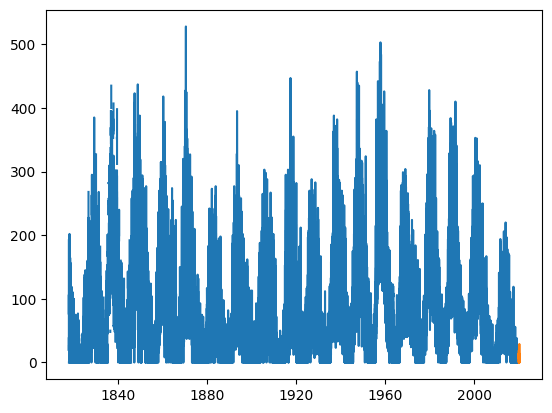

In [5]:
import matplotlib.pyplot as plt

#show training data
plt.plot(training_data)
plt.plot(TESTING_DATA)


In [6]:
#change the column sunspot to numbers
training_data['sunspot'] = pd.to_numeric(training_data['sunspot'], errors='coerce')
#check number of NaN values
training_data.isnull().sum()
#print the longest period of missing values
print("Max number of consecutive Nans before prepro: ", training_data['sunspot'].isnull().astype(int).groupby(training_data['sunspot'].notnull().astype(int).cumsum()).sum().max())

#fill missing values with an interpolation
training_data['sunspot'] = training_data['sunspot'].interpolate()
#check number of NaN values
training_data.isnull().sum()
#print the longest period of missing values
print("Max number of consecutive Nans after prepro: ", training_data['sunspot'].isnull().astype(int).groupby(training_data['sunspot'].notnull().astype(int).cumsum()).sum().max())

Max number of consecutive Nans before prepro:  52
Max number of consecutive Nans after prepro:  0


In [7]:
training_data.values[-1]
print(len(TESTING_DATA))

152


Test RMSE: 7.745


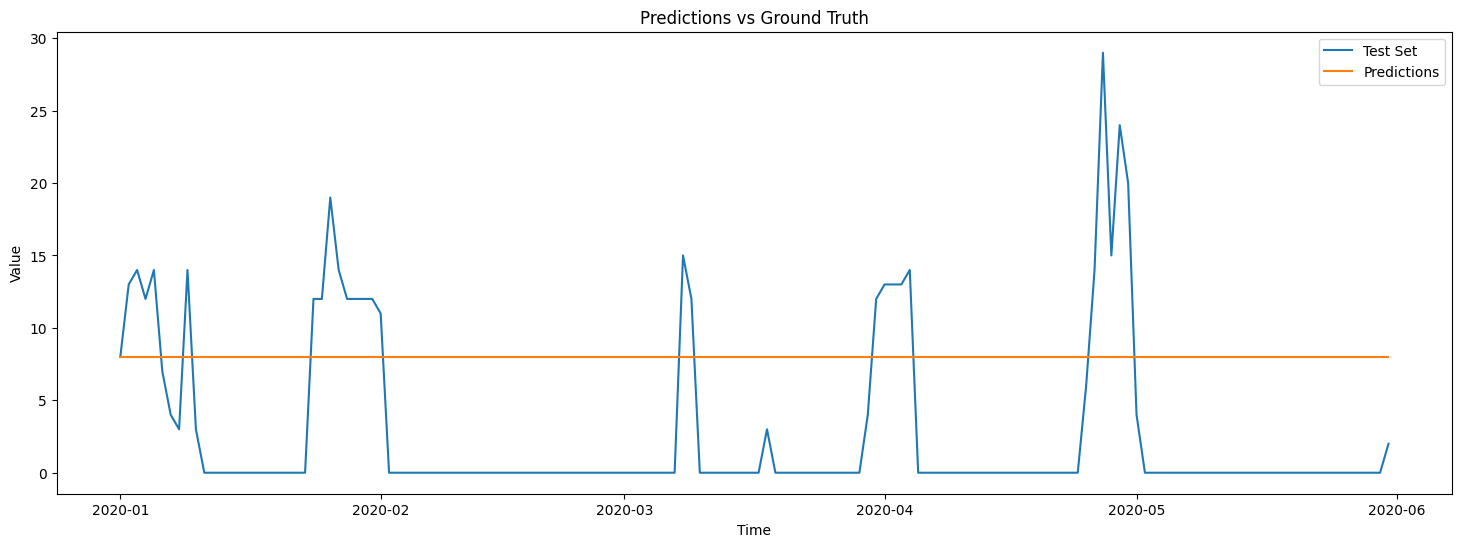

In [10]:
from sklearn.metrics import mean_squared_error

def plot_and_validate(test, predictions):
    if len(test.columns) > 1:
        for i, column in enumerate(test.columns):
            rmse = np.sqrt(mean_squared_error(test[column], predictions[:, i]))
            print(f"Test RMSE for {column}: {rmse:.3f}")
    else:
        rmse = np.sqrt(mean_squared_error(test.values, predictions))
        print(f"Test RMSE: {rmse:.3f}")
        
    plt.figure(figsize=(18,6))
        # Plot test set
    plt.plot(test.index, test, label='Test Set')
    plt.plot(test.index, predictions, label='Predictions')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Predictions vs Ground Truth')
    plt.legend()
    plt.show()


#forecast with persistence model
predictions = [training_data.values[-1]]*len(TESTING_DATA)
# Plot results
plot_and_validate(TESTING_DATA, predictions)

In [ ]:
# Import the required libraries
from statsmodels.tsa.arima.model import ARIMA


# ARIMA model
model_arima = ARIMA(training_data['sunspot'], order=(3,2,10))
model_arima_fit = model_arima.fit()

# Make predictions
predictions_arima = model_arima_fit.predict(start=len(training_data), end=len(training_data) + len(TESTING_DATA) - 1)


Test RMSE: 6.218


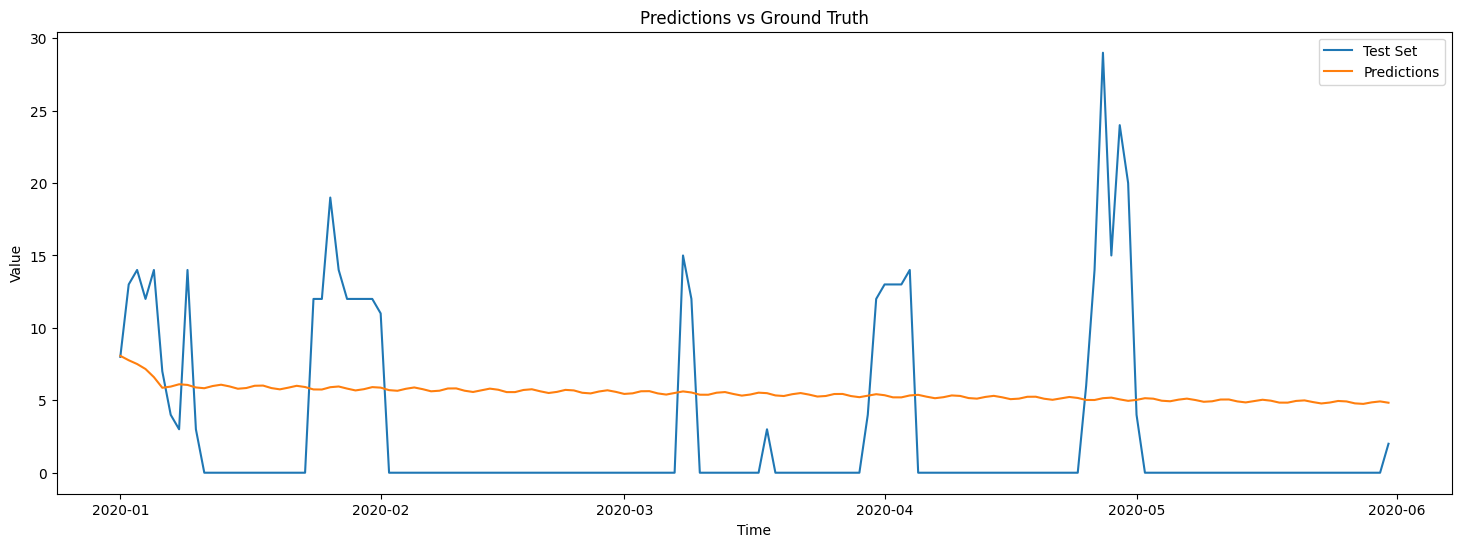

In [ ]:
plot_and_validate(TESTING_DATA, predictions_arima)

In [ ]:
# autoarima
from pmdarima import auto_arima

model_autoarima = auto_arima(training_data['sunspot'], seasonal=True, suppress_warnings=True)
predictions_autoarima = model_autoarima.predict(n_periods=len(TESTING_DATA))

plot_and_validate(TESTING_DATA, predictions_autoarima)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA model
model_sarima = SARIMAX(training_data['sunspot'], order=(3,2,5), seasonal_order=(1, 1, 0, 12))
model_sarima_fit = model_sarima.fit()

# Make predictions
predictions_sarima = model_sarima_fit.predict(start=len(training_data), end=len(training_data) + len(TESTING_DATA) - 1)
plot_and_validate(TESTING_DATA, predictions_sarima)

In [8]:
sliding_window = 48
# Prepare train data
slide_train_df = pd.DataFrame()
for i in range(sliding_window+1):
    for column in training_data.columns:
        slide_train_df[f'{column}-{i}'] = training_data[column].shift(i)

slide_train_df.dropna(inplace=True)
slide_train_df_shuffled = slide_train_df.sample(frac=1, random_state=0)
slide_train_df_x = slide_train_df.iloc[:,1:]
slide_train_df_y = slide_train_df.iloc[:,:1]

/home/ignacio/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test RMSE: 6.045


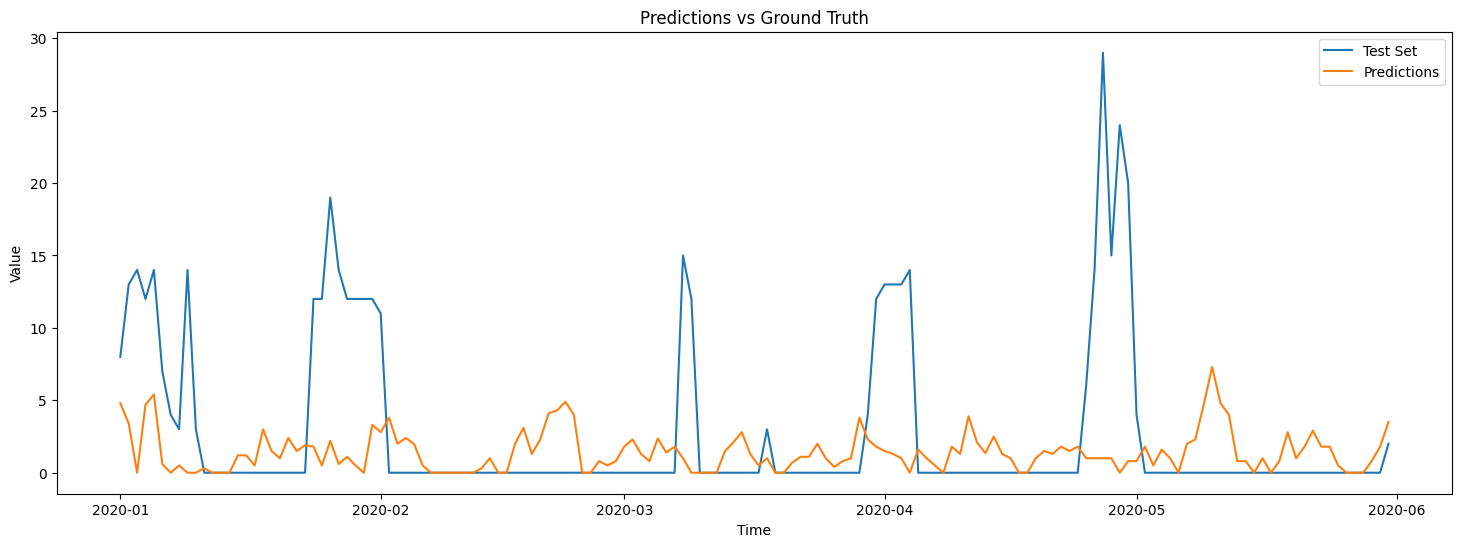

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
model_rf = RandomForestRegressor(n_estimators=10, random_state=0)

# Fit the model
model_rf.fit(slide_train_df_x.values, slide_train_df_y.values)

# Generate predictions
test_inputs = slide_train_df.iloc[-1, 1:].values.reshape(1, -1)
prediction_rf = []
for i in range(len(TESTING_DATA)):
    prediction = model_rf.predict(test_inputs)
    prediction_rf.append(prediction)
    test_inputs = np.roll(test_inputs, 1)
    test_inputs[0, :1] = prediction

plot_and_validate(TESTING_DATA, prediction_rf)

Test RMSE: 5.867


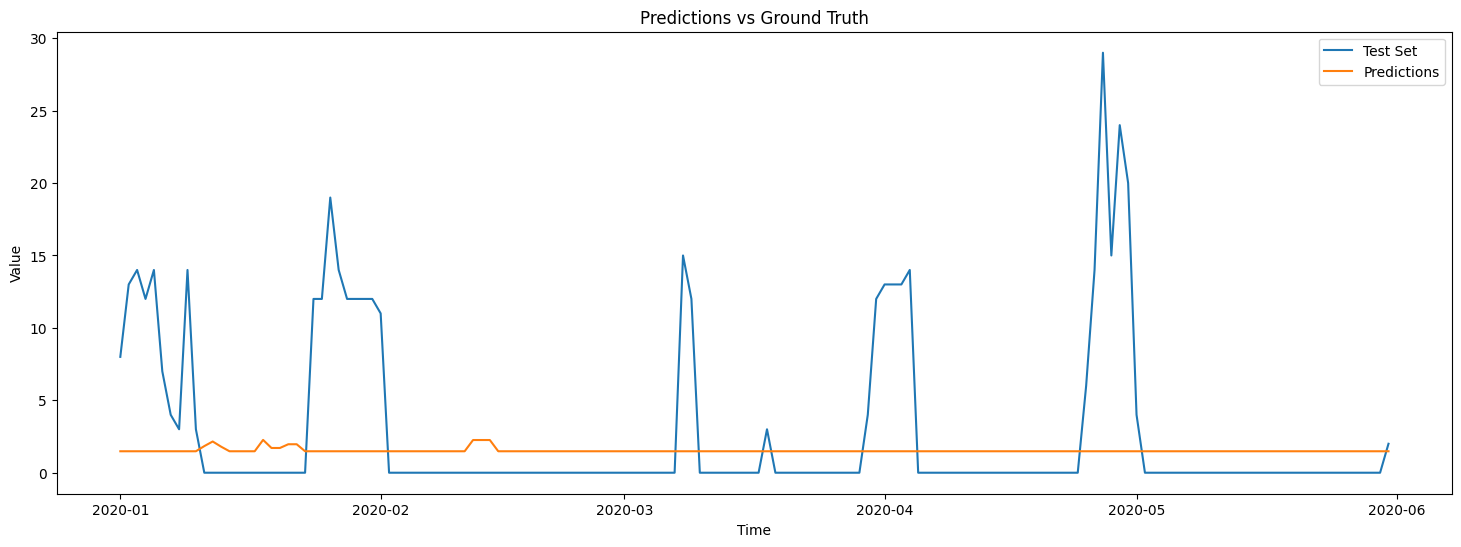

In [51]:
from xgboost import XGBRegressor

# Define the model
model_rf = XGBRegressor(n_estimators=20, random_state=0)

# Fit the model
model_rf.fit(slide_train_df_x.values, slide_train_df_y.values)

# Generate predictions
test_inputs = slide_train_df.iloc[-1, 1:].values.reshape(1, -1)
prediction_rf = []
for i in range(len(TESTING_DATA)):
    prediction = model_rf.predict(test_inputs)
    prediction_rf.append(prediction)
    test_inputs = np.roll(test_inputs, 1)
    test_inputs[0, :1] = prediction

plot_and_validate(TESTING_DATA, prediction_rf)

In [31]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss, QuantileLoss, RMSE

In [147]:
## new dataframe with index and a column for date
training_data2 = training_data.reset_index()
training_data2.columns = ['date', 'sunspot']
## add the index column
training_data2['index'] = training_data2.index
training_data2['series'] = 0

# copy the last 365 days of the training data
testing_data = training_data[-365:].copy()

# concat the testing data to TESTING_DATA
testing_data = pd.concat([testing_data, TESTING_DATA])
testing_data = testing_data.reset_index()
testing_data.columns = ['date', 'sunspot']
testing_data['index'] = testing_data.index
testing_data['series'] = 0

# append 
testing_data

,date,sunspot,index,series
0,2019-01-02,15.0,0,0
1,2019-01-03,15.0,1,0
2,2019-01-04,13.0,2,0
3,2019-01-05,11.0,3,0
4,2019-01-06,0.0,4,0
...,...,...,...,...
512,2020-05-27,0.0,512,0
513,2020-05-28,0.0,513,0
514,2020-05-29,0.0,514,0
515,2020-05-30,0.0,515,0


In [148]:
max_encoder_length = 365
max_prediction_length = 152

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    training_data2,
    time_idx="index",
    target="sunspot",
    group_ids=["series"],
    min_encoder_length=context_length,
    max_encoder_length=context_length,
    min_prediction_length=prediction_length,
    max_prediction_length=prediction_length,
    time_varying_unknown_reals=["sunspot"],
    allow_missing_timesteps=True,
)

testing = TimeSeriesDataSet(
    testing_data,
    time_idx="index",
    target="sunspot",
    group_ids=["series"],
    min_encoder_length=context_length,
    max_encoder_length=context_length,
    min_prediction_length=prediction_length,
    max_prediction_length=prediction_length,
    time_varying_unknown_reals=["sunspot"],
    allow_missing_timesteps=True,
)


validation = TimeSeriesDataSet.from_dataset(training, training_data2, predict=True, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [150]:
for e in test_dataloader:
    print(e[0]['encoder_target'].shape)
    break

torch.Size([1, 365])


In [151]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cuda", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=RMSE(),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.02089296130854039
Restoring states from the checkpoint path at /home/ignacio/Downloads/TS/sertemp-main/exercises/.lr_find_38d03aa6-bcb9-4c03-85e7-3c4d92349019.ckpt
Restored all states from the checkpoint at /home/ignacio/Downloads/TS/sertemp-main/exercises/.lr_find_38d03aa6-bcb9-4c03-85e7-3c4d92349019.ckpt


suggested learning rate: 0.02089296130854039


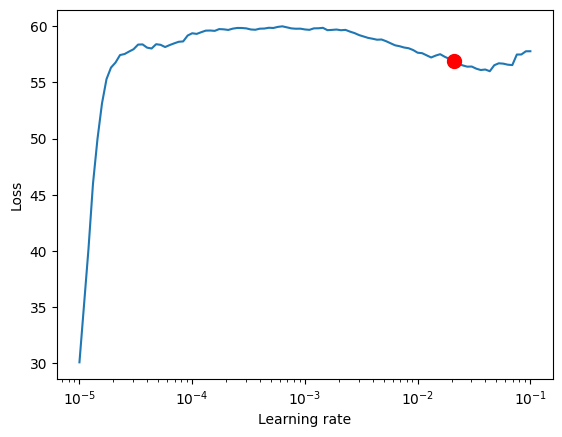

/tmp/ipykernel_118910/2821873794.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [152]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [153]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params
---------------------------------------------------
0 | loss            | RMSE           | 0     
1 | logging_metrics | ModuleList     | 0     
2 | embeddings      | MultiEmbedding | 0     
3 | model           | NHiTS          | 120 K 
---------------------------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.483     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [154]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [155]:
predictions = best_model.predict(test_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
RMSE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


tensor(5.5265)

In [156]:
raw_predictions = best_model.predict(test_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


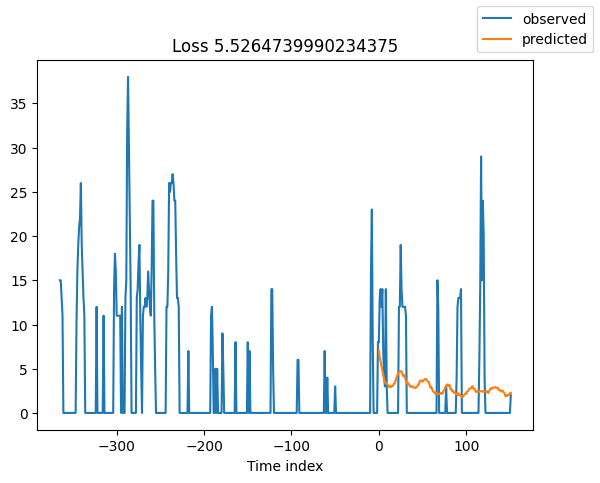

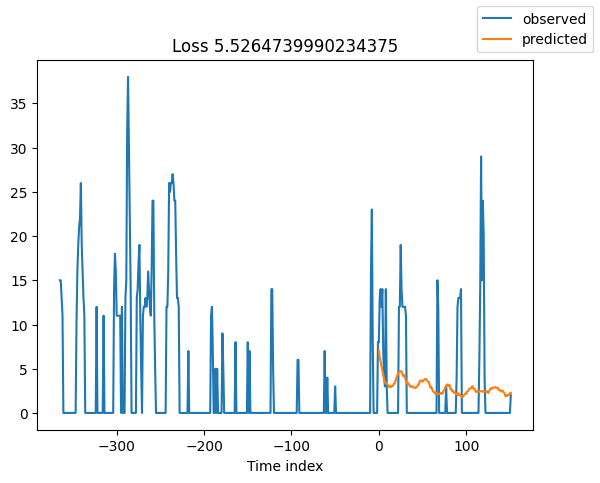

In [163]:
best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)

In [166]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params
---------------------------------------------------
0 | loss            | RMSE           | 0     
1 | logging_metrics | ModuleList     | 0     
2 | embeddings      | MultiEmbedding | 0     
3 | model           | NHiTS          | 120 K 
---------------------------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.483     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [167]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)
predictions = best_model.predict(test_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
RMSE()(predictions.output, predictions.y)

/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/ignacio/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The '

tensor(5.6948)